In [1]:
import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from gala.units import galactic
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic, binned_statistic_2d

%matplotlib inline

In [2]:
ipl = at.Table.read("IPL3/astraAllStarASPCAP-0.5.0.fits.gz", hdu=2)

In [3]:
print(f"{(~ipl['sdss4_apogee_id'].mask).sum()} spectra in DR17")
print(f"{(ipl['sdss4_apogee_id'].mask).sum()} spectra new to MWM")

754292 spectra in DR17
305229 spectra new to MWM


In [4]:
unq_ipl = at.unique(ipl, keys="sdss_id")
in_dr17_mask = ~unq_ipl["sdss4_apogee_id"].mask
new_mwm_mask = unq_ipl["sdss4_apogee_id"].mask

In [5]:
import agama
agama.setUnits(length=u.kpc, time=u.Myr, mass=u.Msun)

# Coordinates, potential, etc. (i.e. assumptions)

In [6]:
c = coord.SkyCoord(
    ra=unq_ipl["ra"] * u.deg,
    dec=unq_ipl["dec"] * u.deg,
    # distance=coord.Distance(parallax=unq_ipl["plx"] * u.mas, allow_negative=True),
    distance=unq_ipl["r_med_photogeo"] * u.pc,
    pm_ra_cosdec=unq_ipl["pmra"] * u.mas / u.yr,
    pm_dec=unq_ipl["pmde"] * u.mas / u.yr,
    radial_velocity=unq_ipl["v_rad"] * u.km / u.s,
)

In [7]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.3 * u.kpc, galcen_v_sun=[8.0, 254.0, 8.0] * u.km / u.s
)
galcen = c.transform_to(galcen_frame)

In [8]:
mw = gp.MilkyWayPotential2022()
w = gd.PhaseSpacePosition(galcen.data)

In [9]:
R = w.cylindrical.rho
vR = w.cylindrical.v_rho
vphi = (w.cylindrical.pm_phi * R).to(u.km / u.s, u.dimensionless_angles())

Lz = np.abs(w.angular_momentum()[2])
Rg = w.guiding_radius(mw)

/mnt/ceph/users/apricewhelan/projects/gala/gala/dynamics/core.py:903: RuntimeWarning: invalid value encountered in sqrt
  vc = np.sqrt(R * np.abs(dPhi_dR))


In [10]:
agama_mw = mw.as_interop("agama")
af = agama.ActionFinder(agama_mw)
aaf = af(w.w(units=galactic).T, angles=True)

JR = aaf[0][:, 0] * u.kpc**2/u.Myr
Jz = aaf[0][:, 1] * u.kpc**2/u.Myr

zmax = np.sqrt(aaf[0][:, 1] / aaf[2][:, 1]) * 2 / np.sqrt(2) * u.kpc

In [11]:
unq_ipl["xyz"] = w.xyz.T
unq_ipl["vxyz"] = w.v_xyz.T
unq_ipl["R"] = R
unq_ipl["vR"] = vR
unq_ipl["vphi"] = vphi
unq_ipl["Rguide"] = Rg
unq_ipl["zmax"] = zmax

# MS / Giants

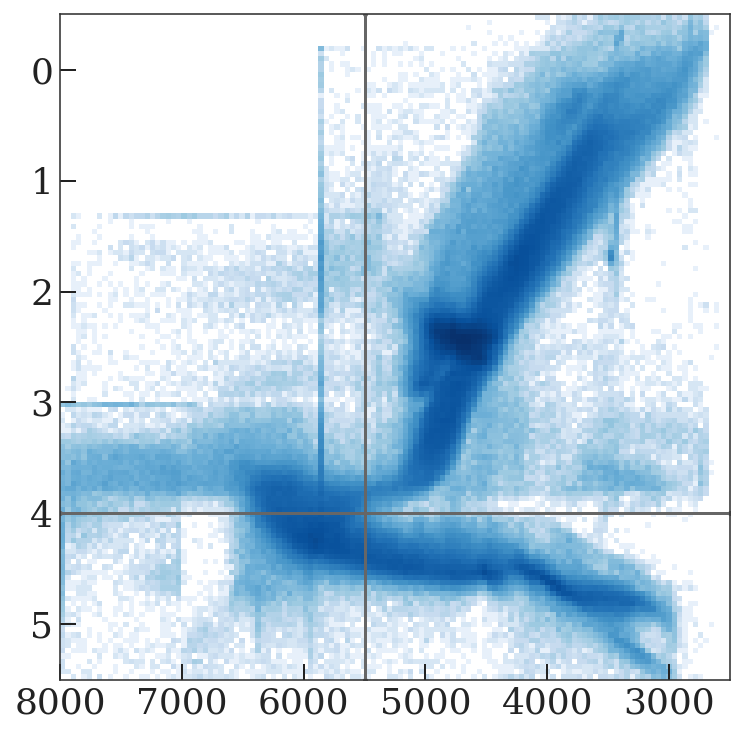

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = (np.linspace(2500, 8000, 128), np.linspace(-0.5, 5.5, 128))
ax.hist2d(
    unq_ipl["teff"],
    unq_ipl["logg"],
    bins=bins,
    norm=mpl.colors.LogNorm(vmin=0.5),
    cmap="Blues",
)
ax.set(xlim=(bins[0].max(), bins[0].min()), ylim=(bins[1].max(), bins[1].min()))

ax.axvline(5500)
ax.axhline(4.0)

In [13]:
rgb_mask = (unq_ipl["teff"] < 5500) & (unq_ipl["teff"] > 2500) & (unq_ipl["logg"] < 4.0)
ms_mask = (
    (~rgb_mask)
    & (unq_ipl["teff"] < 1e4)
    & (unq_ipl["teff"] > 2500)
    & (unq_ipl["logg"] > 3.0)
)
rgb_mask.sum(), ms_mask.sum()

(568521, 349225)

# Alpha / Iron

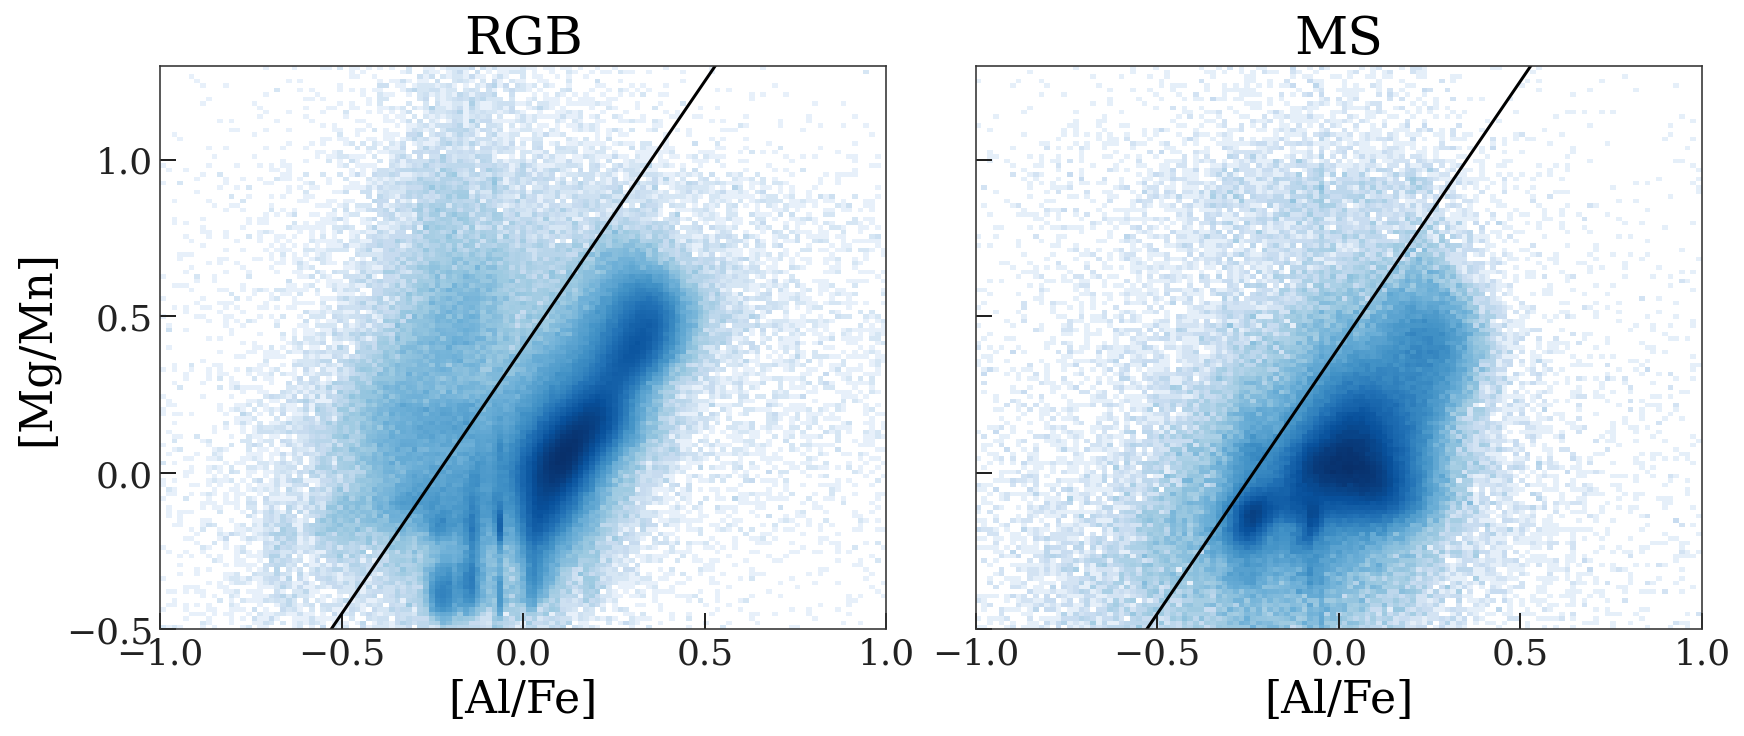

In [14]:
alfe = unq_ipl["al_h"] - unq_ipl["fe_h"]
mgmn = unq_ipl["mg_h"] - unq_ipl["mn_h"]

fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)

for ax, name, mask in zip(axes, ["RGB", "MS"], [rgb_mask, ms_mask]):
    ax.hist2d(
        alfe[mask],
        mgmn[mask],
        bins=(np.linspace(-1, 1, 128), np.linspace(-0.5, 1.3, 128)),
        norm=mpl.colors.LogNorm(vmin=0.5),
        cmap="Blues",
    )
    
    xx = np.linspace(-1, 1, 55)
    ax.plot(xx, 1.7 * xx + 0.4, marker='')
    
    ax.set_title(name)
    ax.set_xlabel("[Al/Fe]")
    
axes[0].set_ylabel("[Mg/Mn]")

mgmn_alfe_mask = mgmn < (1.7 * alfe + 0.4)

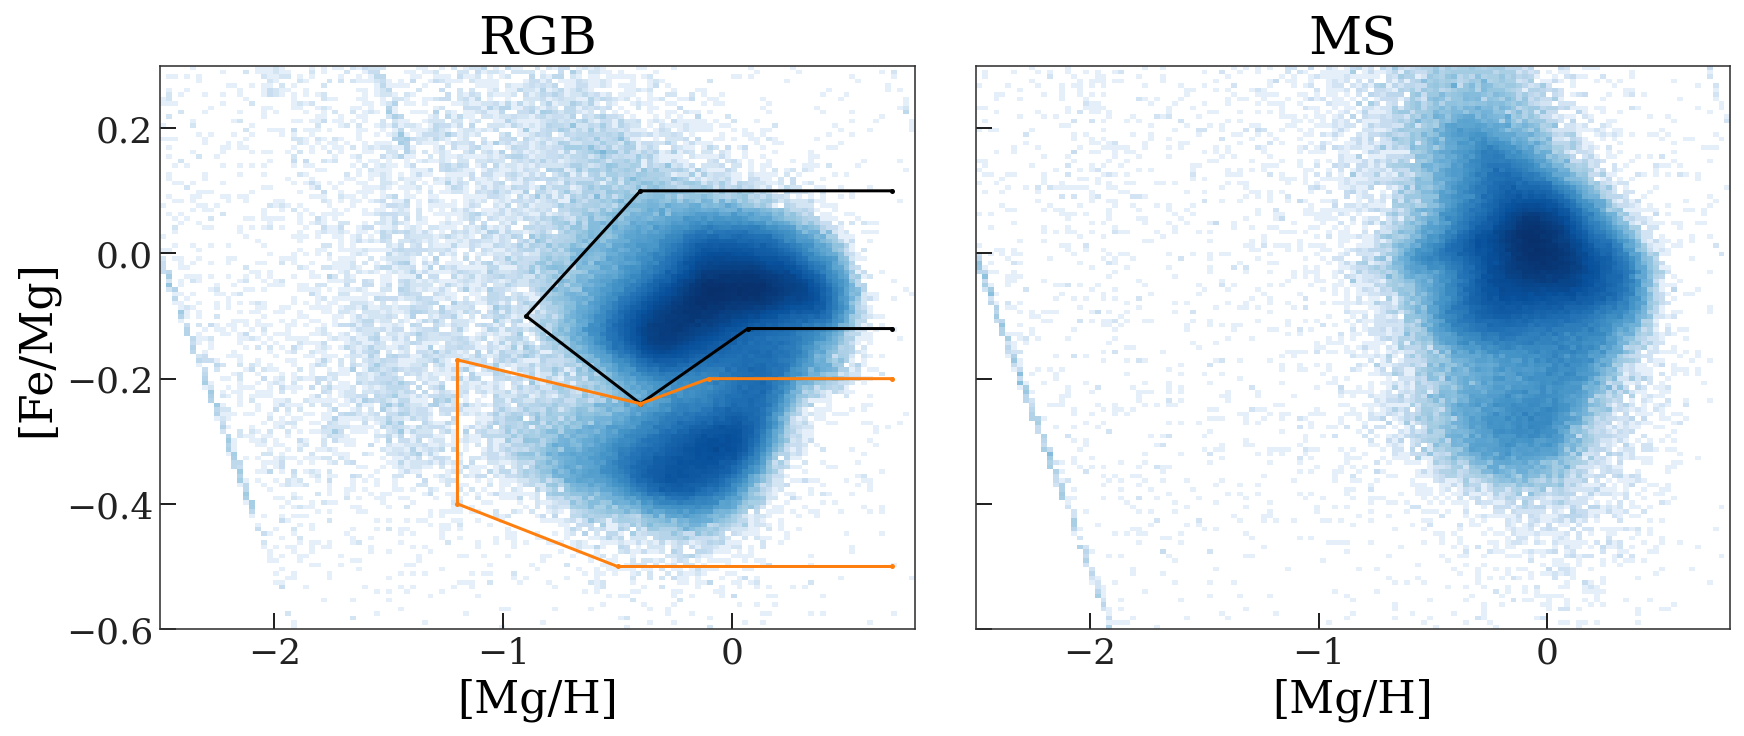

In [15]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)

for ax, name, mask in zip(axes, ["RGB", "MS"], [rgb_mask, ms_mask]):
    ax.hist2d(
        unq_ipl["mg_h"][mask & mgmn_alfe_mask],
        (unq_ipl["fe_h"] - unq_ipl["mg_h"])[mask & mgmn_alfe_mask],
        bins=(np.linspace(-2.5, 0.8, 128), np.linspace(-0.6, 0.3, 128)),
        norm=mpl.colors.LogNorm(vmin=0.5),
        cmap="Blues",
    )
    ax.set_title(name)
    ax.set_xlabel("[Mg/H]")
axes[0].set_ylabel("[Fe/Mg]")

# Low alpha:
nodes = np.array(
    [[0.7, -0.12], [0.07, -0.12], [-0.4, -0.24], [-0.9, -0.1], [-0.4, 0.1], [0.7, 0.1]]
)
axes[0].plot(nodes[:, 0], nodes[:, 1])
poly = mpl.path.Path(nodes)
X = np.stack(
    [x.filled(np.nan) for x in [unq_ipl["mg_h"], unq_ipl["fe_h"] - unq_ipl["mg_h"]]]
).T
low_alpha_mask = poly.contains_points(X) & mgmn_alfe_mask

# High alpha:
nodes = np.array(
    [[0.7, -0.2], [-0.1, -0.2], [-0.4, -0.24], [-1.2, -0.17], [-1.2, -0.4], [-0.5, -0.5], [0.7, -0.5]]
)
axes[0].plot(nodes[:, 0], nodes[:, 1], color="tab:orange")
poly = mpl.path.Path(nodes)
X = np.stack(
    [x.filled(np.nan) for x in [unq_ipl["mg_h"], unq_ipl["fe_h"] - unq_ipl["mg_h"]]]
).T
high_alpha_mask = poly.contains_points(X) & mgmn_alfe_mask

In [16]:
(low_alpha_mask & rgb_mask).sum(), (high_alpha_mask & rgb_mask).sum()

(360727, 120945)

In [17]:
(low_alpha_mask & rgb_mask & new_mwm_mask).sum(), (
    high_alpha_mask & rgb_mask & new_mwm_mask
).sum()

(127832, 32061)

In [18]:
rgb_subset = unq_ipl[rgb_mask]
rgb_subset["low_alpha"] = low_alpha_mask[rgb_mask]
rgb_subset["high_alpha"] = high_alpha_mask[rgb_mask]
# rgb_subset.write("IPL3/RGB-kinematics-alphamask.fits", overwrite=True)

# Galactic position

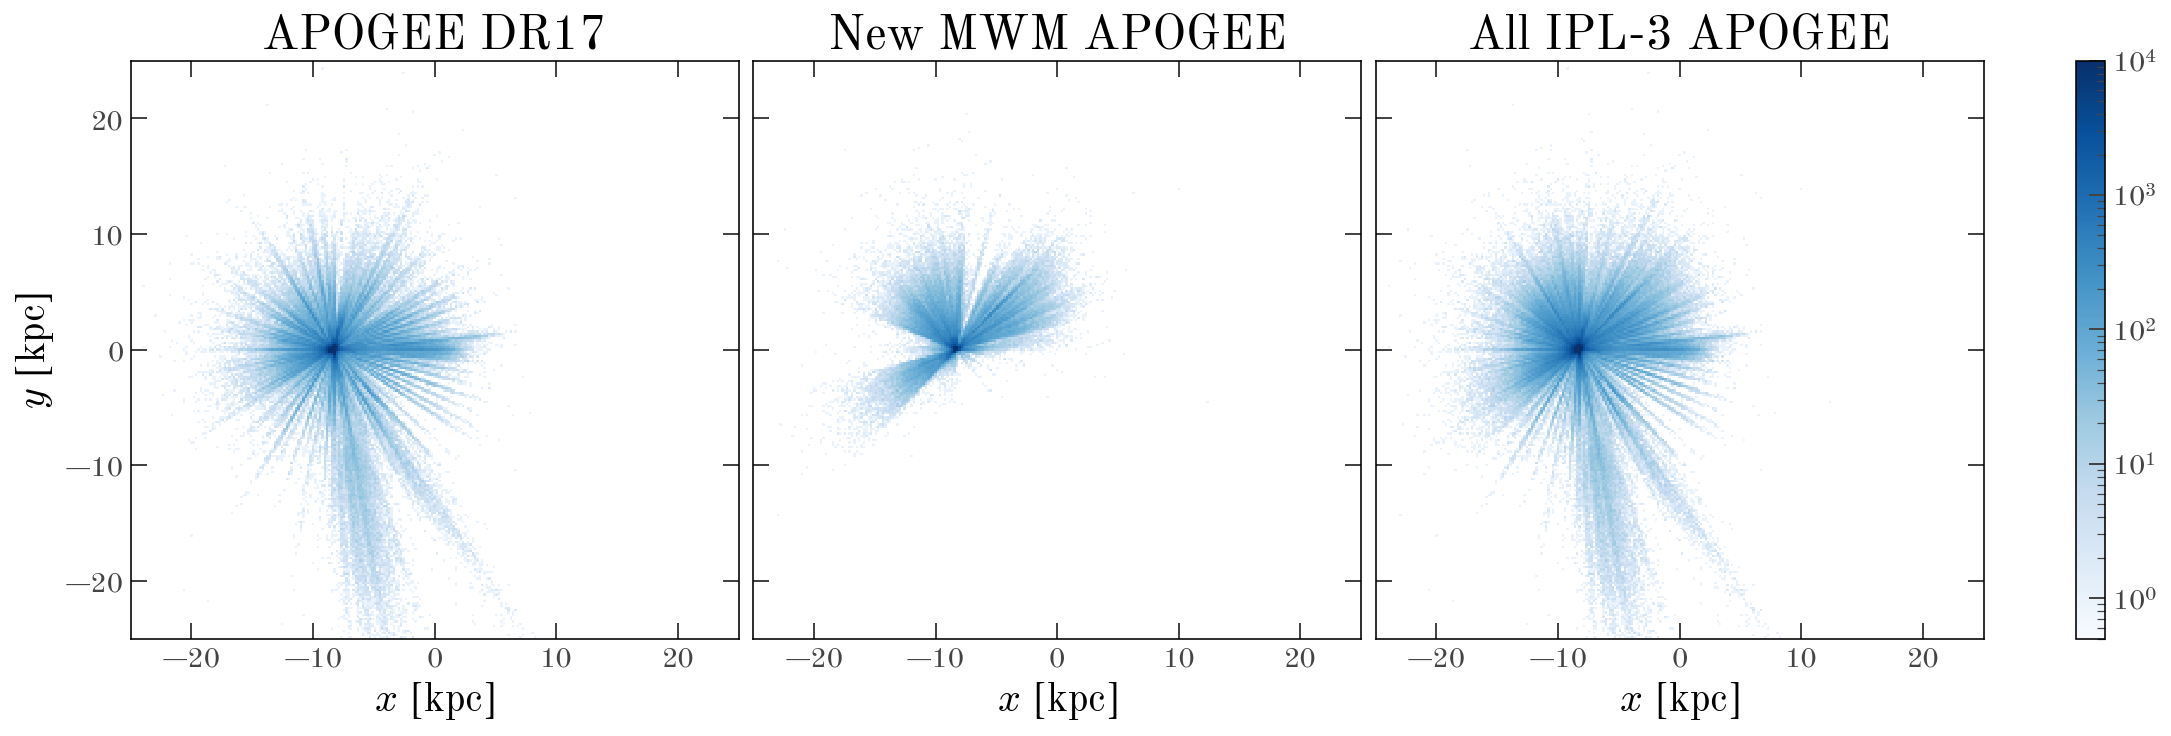

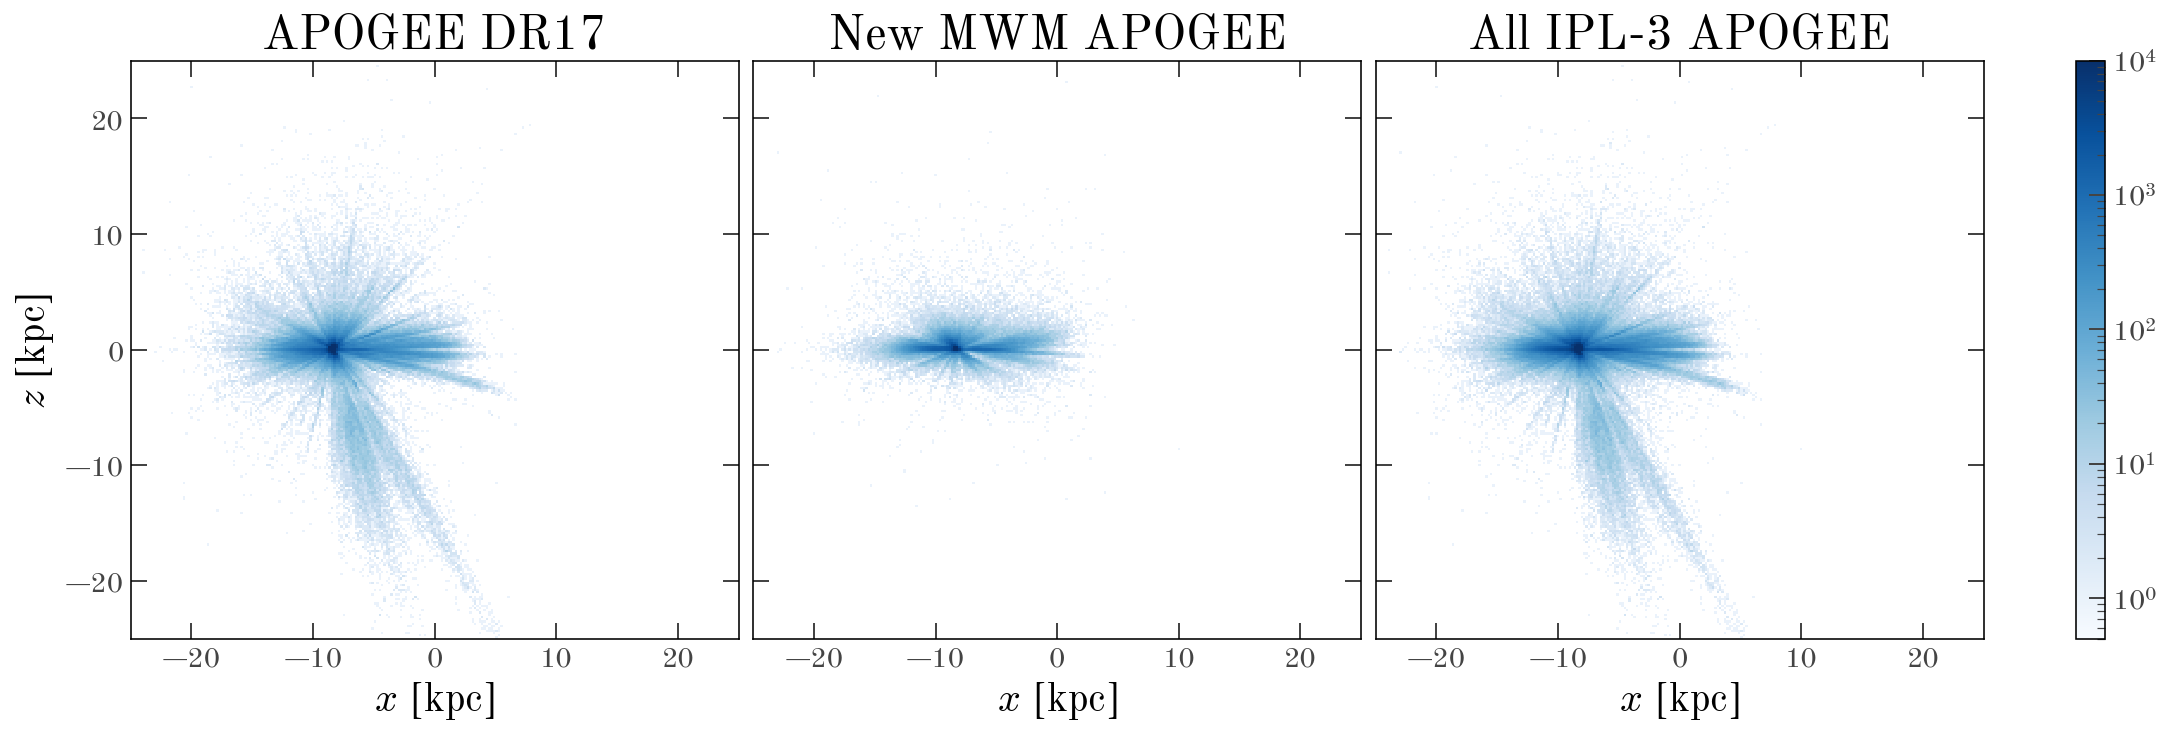

In [58]:
bins = np.linspace(-25, 25, 256)
cmap = plt.get_cmap("Blues")
kw = dict(bins=bins, norm=mpl.colors.LogNorm(vmin=0.5, vmax=1e4), cmap=cmap)

for h in ["y", "z"]:
    fig, axes = plt.subplots(
        1, 3, figsize=(15, 5), sharex=True, sharey=True, layout="constrained"
    )

    axes[0].hist2d(
        galcen.x[in_dr17_mask].to_value(u.kpc),
        getattr(galcen, h)[in_dr17_mask].to_value(u.kpc),
        **kw,
    )
    axes[0].set_title("APOGEE DR17")

    axes[1].hist2d(
        galcen.x[new_mwm_mask].to_value(u.kpc),
        getattr(galcen, h)[new_mwm_mask].to_value(u.kpc),
        **kw,
    )
    axes[1].set_title("New MWM APOGEE")

    axes[2].hist2d(galcen.x.to_value(u.kpc), getattr(galcen, h).to_value(u.kpc), **kw)
    axes[2].set_title("All IPL-3 APOGEE")

    for ax in axes:
        ax.set_xlabel("$x$ [kpc]")
    axes[0].set_ylabel(f"${h}$ [kpc]")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=kw["norm"])
    cb = fig.colorbar(sm, ax=axes)

# Face-on and edge-on abundance maps

In [303]:
xy_size = 30
xy_bins = (
    np.arange(-xy_size / 2 - 8, xy_size / 2 - 8 + 1e-3, 0.1),
    np.arange(-xy_size / 2, xy_size / 2 + 1e-3, 0.1),
)
xz_bins = (
    np.arange(-xy_size / 2 - 8, xy_size / 2 - 8 + 1e-3, 0.1),
    np.arange(-10, 10 + 1e-3, 0.1),
)
Rz_bins = (
    np.arange(0, 25 + 1e-3, 0.1),
    np.arange(-8, 8 + 1e-3, 0.1),
)

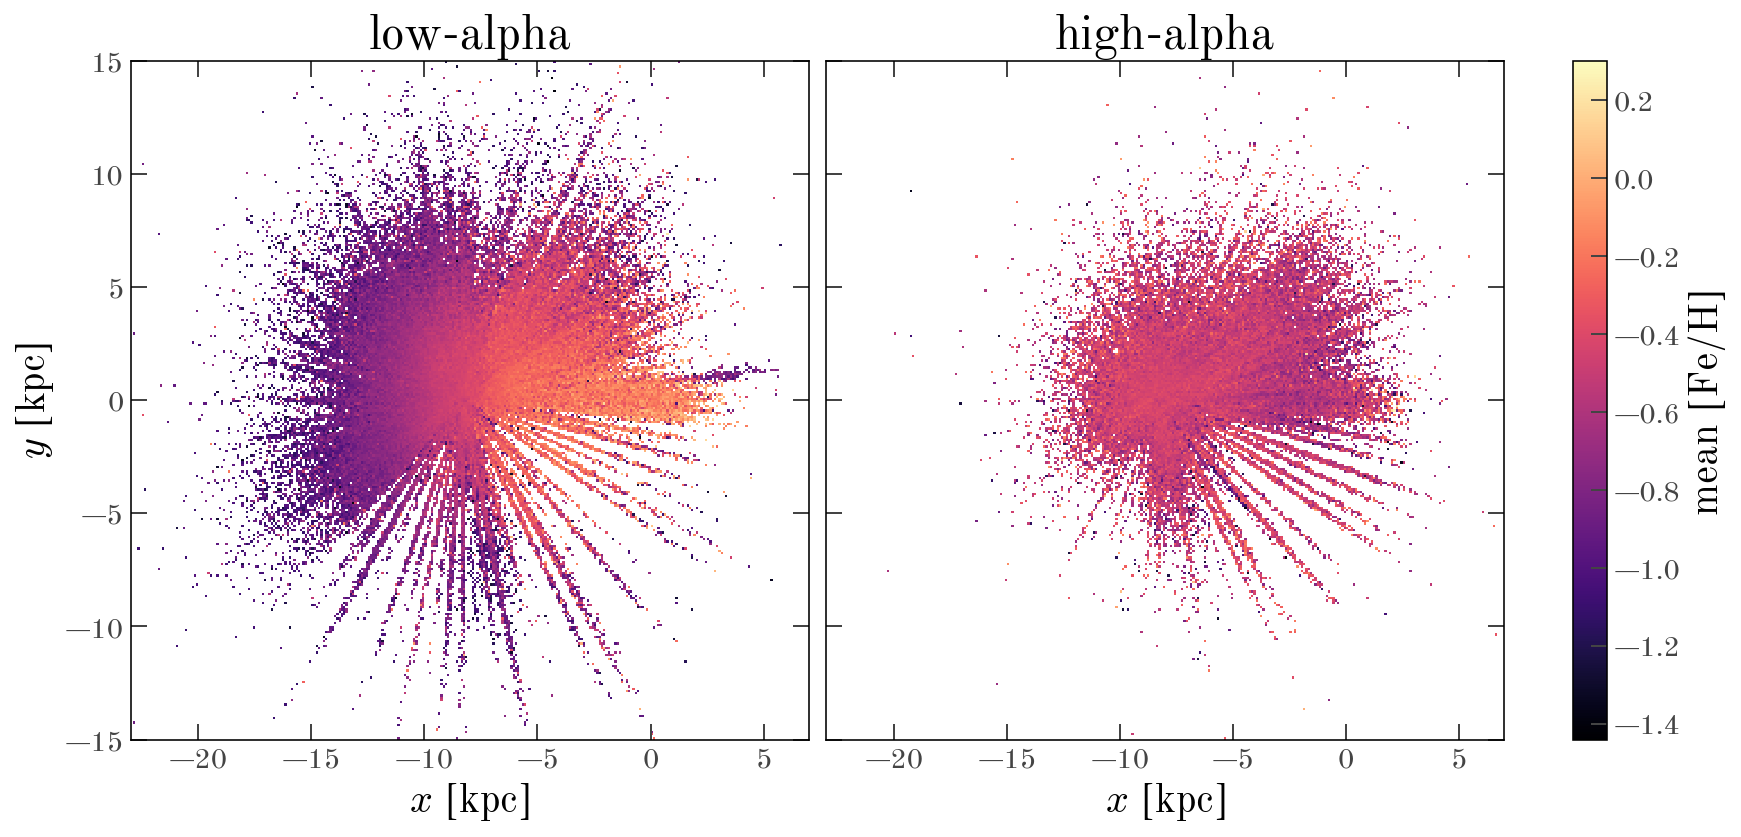

In [292]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5.7), sharex=True, sharey=True, layout="constrained"
)
for ax, alpha_mask, name in zip(
    axes, [low_alpha_mask, high_alpha_mask], ["low-alpha", "high-alpha"]
):
    mask = rgb_mask & alpha_mask & (np.abs(galcen.z) < 5 * u.kpc)
    stat = binned_statistic_2d(
        galcen.x[mask].to_value(u.kpc),
        galcen.y[mask].to_value(u.kpc),
        unq_ipl["fe_h"][mask],
        bins=xy_bins,
    )
    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T)
    ax.set_xlabel("$x$ [kpc]")
    ax.set_title(name)
axes[0].set_ylabel("$y$ [kpc]")

cb = fig.colorbar(cs, ax=axes)
cb.set_label("mean [Fe/H]")

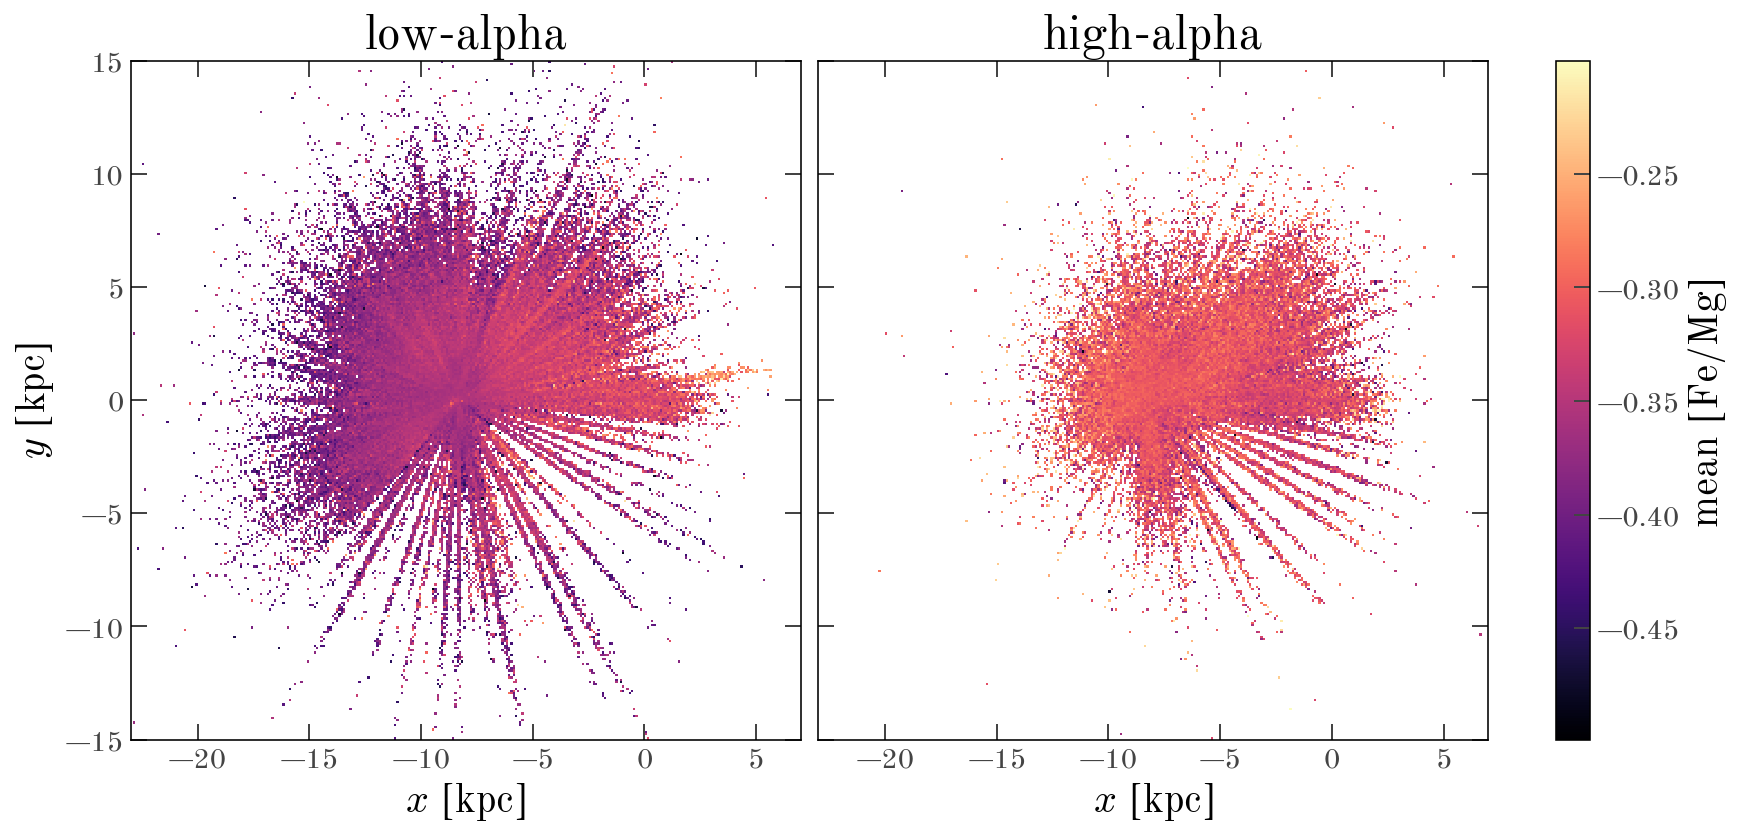

In [293]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5.7), sharex=True, sharey=True, layout="constrained"
)
for ax, alpha_mask, name in zip(
    axes, [low_alpha_mask, high_alpha_mask], ["low-alpha", "high-alpha"]
):
    mask = rgb_mask & alpha_mask & (np.abs(galcen.z) < 5 * u.kpc)
    stat = binned_statistic_2d(
        galcen.x[mask].to_value(u.kpc),
        galcen.y[mask].to_value(u.kpc),
        (unq_ipl["fe_h"] - unq_ipl["mg_h"])[mask],
        bins=xy_bins,
    )
    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T)
    ax.set_xlabel("$x$ [kpc]")
    ax.set_title(name)
axes[0].set_ylabel("$y$ [kpc]")

cb = fig.colorbar(cs, ax=axes)
cb.set_label("mean [Fe/Mg]")

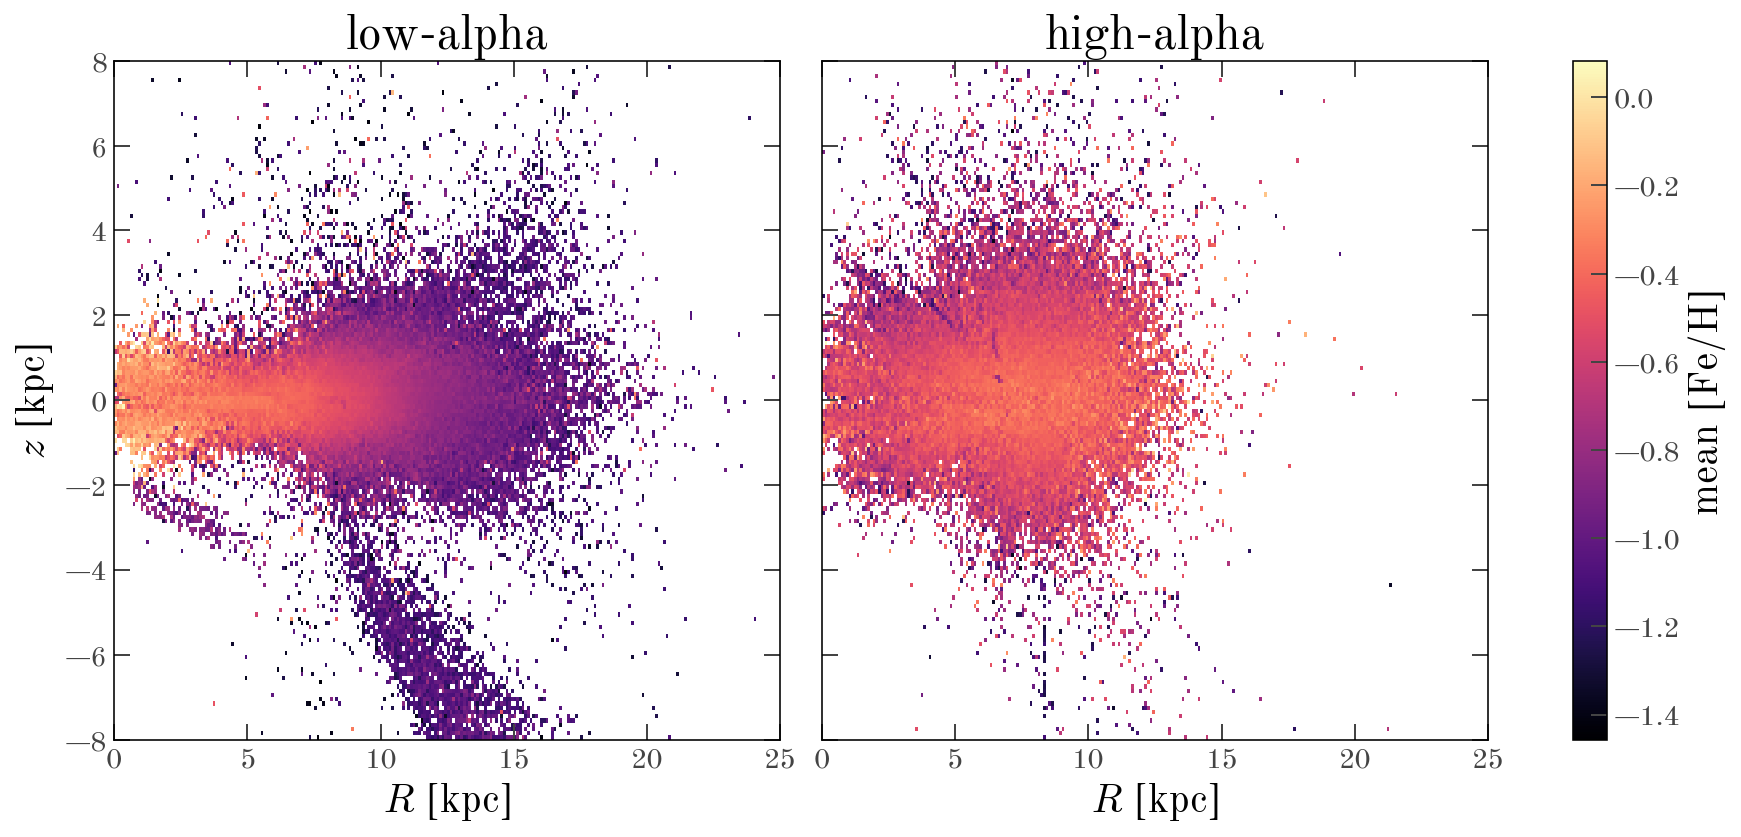

In [304]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5.7), sharex=True, sharey=True, layout="constrained"
)
for ax, alpha_mask, name in zip(
    axes, [low_alpha_mask, high_alpha_mask], ["low-alpha", "high-alpha"]
):
    mask = rgb_mask & alpha_mask
    stat = binned_statistic_2d(
        R[mask].to_value(u.kpc),
        galcen.z[mask].to_value(u.kpc),
        unq_ipl["fe_h"][mask],
        bins=Rz_bins,
    )
    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T)
    ax.set_xlabel("$R$ [kpc]")
    ax.set_title(name)
axes[0].set_ylabel("$z$ [kpc]")

cb = fig.colorbar(cs, ax=axes)
cb.set_label("mean [Fe/H]")

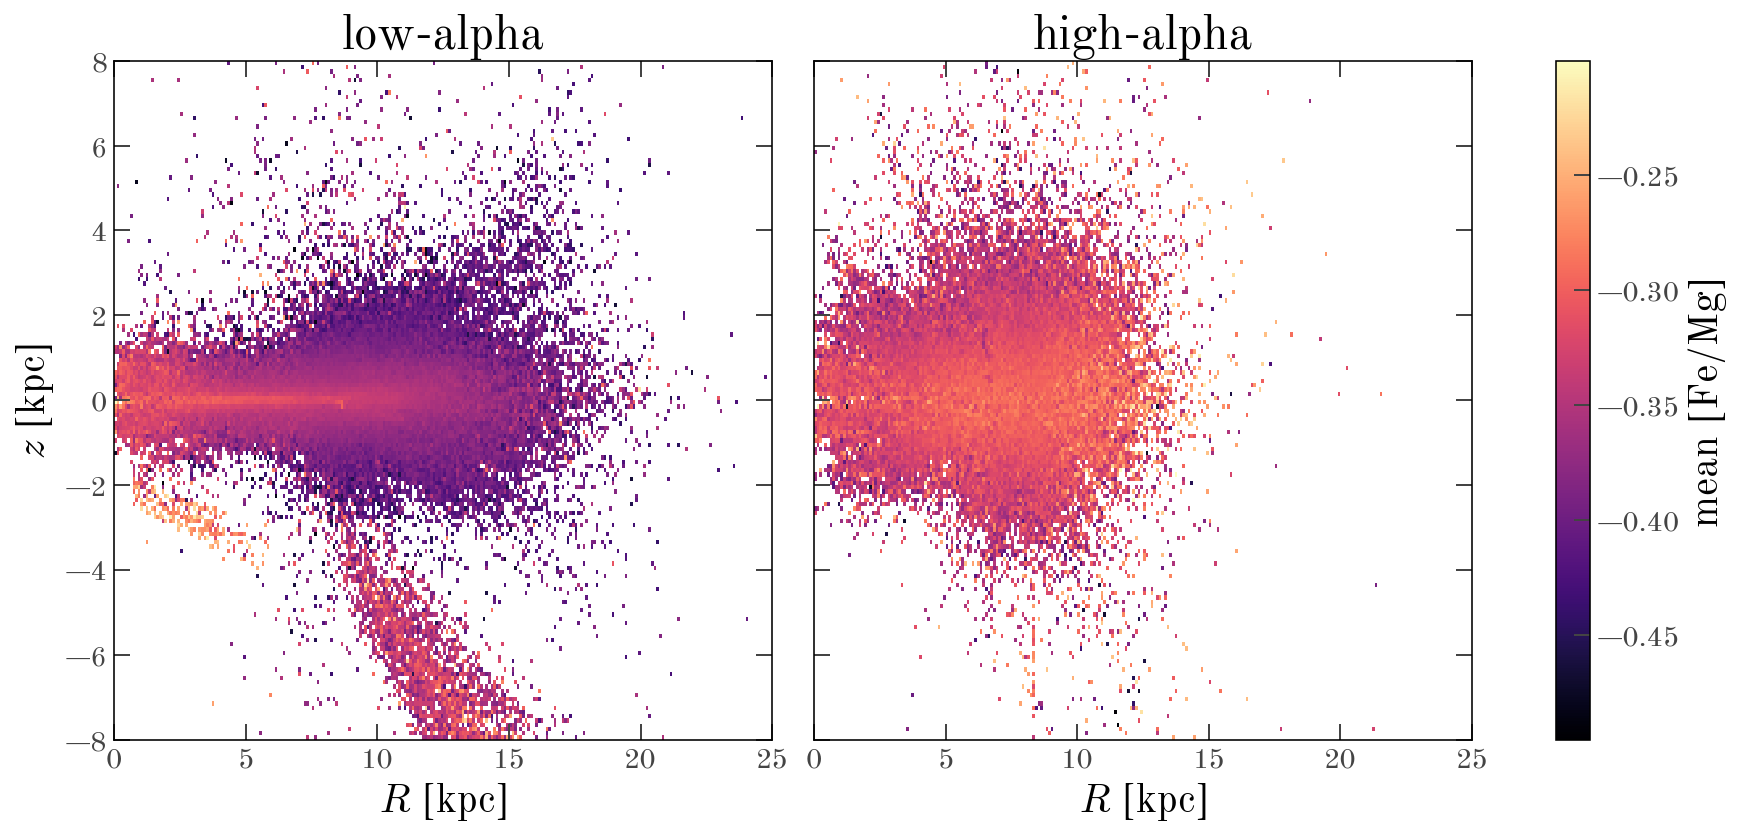

In [305]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5.7), sharex=True, sharey=True, layout="constrained"
)
for ax, alpha_mask, name in zip(
    axes, [low_alpha_mask, high_alpha_mask], ["low-alpha", "high-alpha"]
):
    mask = rgb_mask & alpha_mask
    stat = binned_statistic_2d(
        R[mask].to_value(u.kpc),
        galcen.z[mask].to_value(u.kpc),
        (unq_ipl["fe_h"] - unq_ipl["mg_h"])[mask],
        bins=Rz_bins,
    )
    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T)
    ax.set_xlabel("$R$ [kpc]")
    ax.set_title(name)
axes[0].set_ylabel("$z$ [kpc]")

cb = fig.colorbar(cs, ax=axes)
cb.set_label("mean [Fe/Mg]")

# Radial abundance gradient

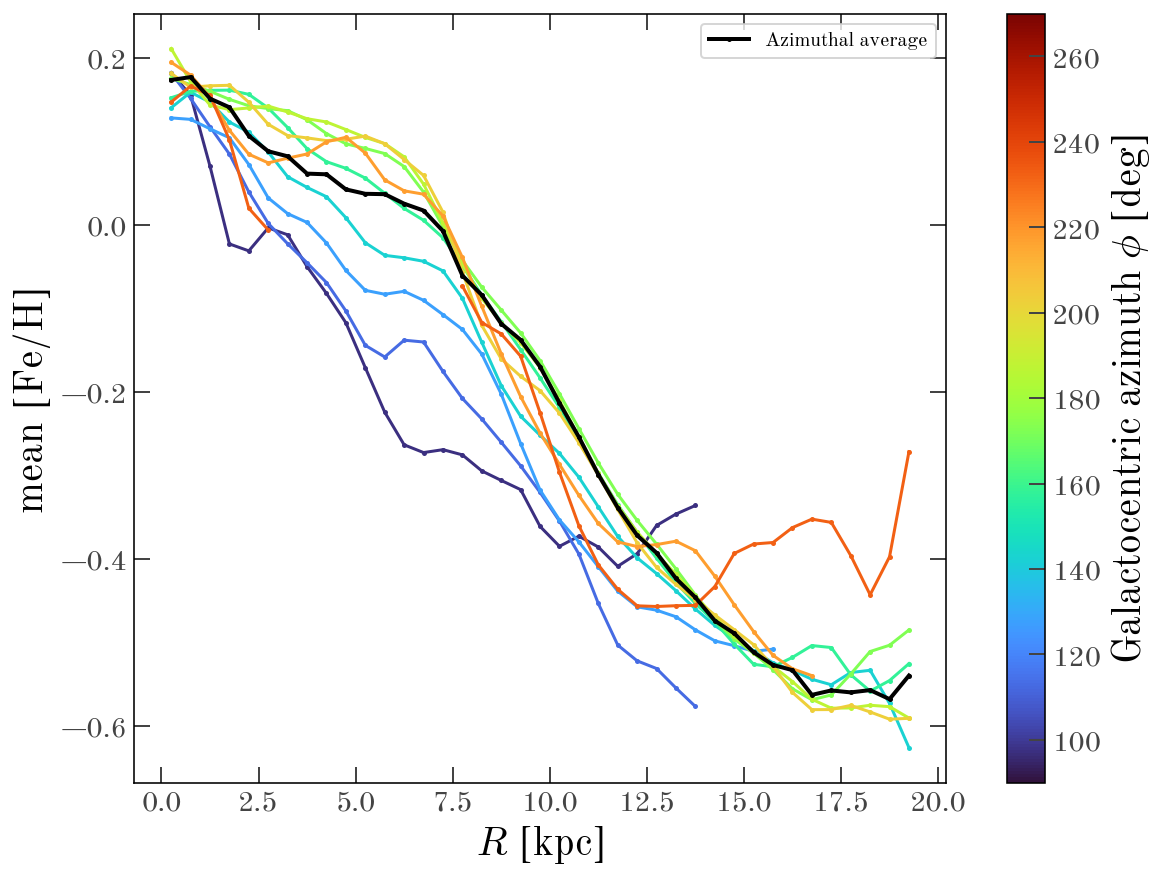

In [306]:
tmp_bins = (
    np.arange(90, 270 + 1e-3, 15),
    np.arange(0, 20, 0.5),
)

mask = rgb_mask & low_alpha_mask & (np.abs(galcen.z) < 3 * u.kpc)
stat = binned_statistic_2d(
    w.cylindrical.phi[mask].wrap_at(360 * u.deg).to_value(u.deg),
    R[mask].to_value(u.kpc),
    unq_ipl["fe_h"][mask],
    bins=tmp_bins,
)
counts, *_ = np.histogram2d(
    w.cylindrical.phi[mask].wrap_at(360 * u.deg).to_value(u.deg),
    R[mask].to_value(u.kpc),
    bins=tmp_bins,
)
counts_mask = counts.sum(axis=1) > 1e3

mean_stat = binned_statistic(
    R[mask].to_value(u.kpc), unq_ipl["fe_h"][mask], bins=tmp_bins[1]
)

cmap = plt.get_cmap("turbo")
norm = mpl.colors.Normalize(tmp_bins[0].min(), tmp_bins[0].max())

tmp_binc1 = 0.5 * (tmp_bins[1][:-1] + tmp_bins[1][1:])
tmp_binc0 = 0.5 * (tmp_bins[0][:-1] + tmp_bins[0][1:])
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")

for i in np.where(counts_mask)[0]:  # range(stat.statistic.shape[0]):
    ax.plot(
        tmp_binc1,
        gaussian_filter1d(stat.statistic[i], 1),
        color=cmap(norm(tmp_binc0[i])),
    )

ax.plot(
    0.5 * (mean_stat.bin_edges[:-1] + mean_stat.bin_edges[1:]),
    mean_stat.statistic,
    lw=2,
    color="k",
    label="Azimuthal average",
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, ax=ax)
cb.set_label("Galactocentric azimuth $\phi$ [deg]")

ax.set(xlabel="$R$ [kpc]", ylabel="mean [Fe/H]")
ax.legend()

In [297]:
R_interp = InterpolatedUnivariateSpline(
    0.5 * (mean_stat.bin_edges[:-1] + mean_stat.bin_edges[1:]),
    gaussian_filter1d(mean_stat.statistic, 1),
    k=3,
)

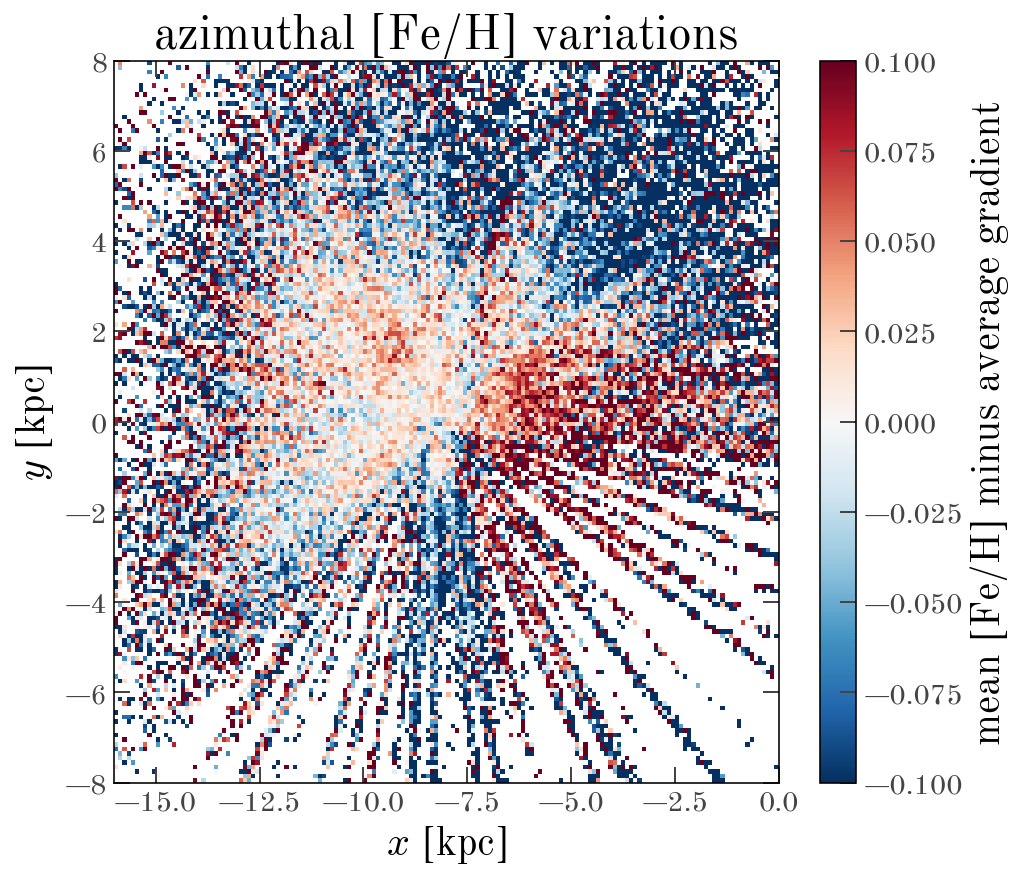

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), layout="constrained")

mask = rgb_mask & low_alpha_mask & (np.abs(galcen.z) < 3 * u.kpc)
stat = binned_statistic_2d(
    galcen.x[mask].to_value(u.kpc),
    galcen.y[mask].to_value(u.kpc),
    unq_ipl["fe_h"][mask],
    bins=xy_bins,
)
xc, yc = np.meshgrid(
    0.5 * (stat.x_edge[:-1] + stat.x_edge[1:]),
    0.5 * (stat.y_edge[:-1] + stat.y_edge[1:]),
)
_Rc = np.sqrt(xc**2 + yc**2)
smooth_stat = R_interp(_Rc)
cs = ax.pcolormesh(
    stat.x_edge,
    stat.y_edge,
    stat.statistic.T - smooth_stat,
    cmap="RdBu_r",
    vmin=-0.1,
    vmax=0.1,
)
ax.set(
    xlabel="$x$ [kpc]",
    ylabel="$y$ [kpc]",
    title="azimuthal [Fe/H] variations",
    xlim=(-16, 0),
    ylim=(-8, 8),
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] minus average gradient")

# Vertical abundance gradient

[Text(0.5, 0, '$z$ [kpc]'),
 Text(0, 0.5, 'mean [Fe/Mg] per pixel'),
 Text(0.5, 1.0, 'Galactic warp in RGB stars?')]

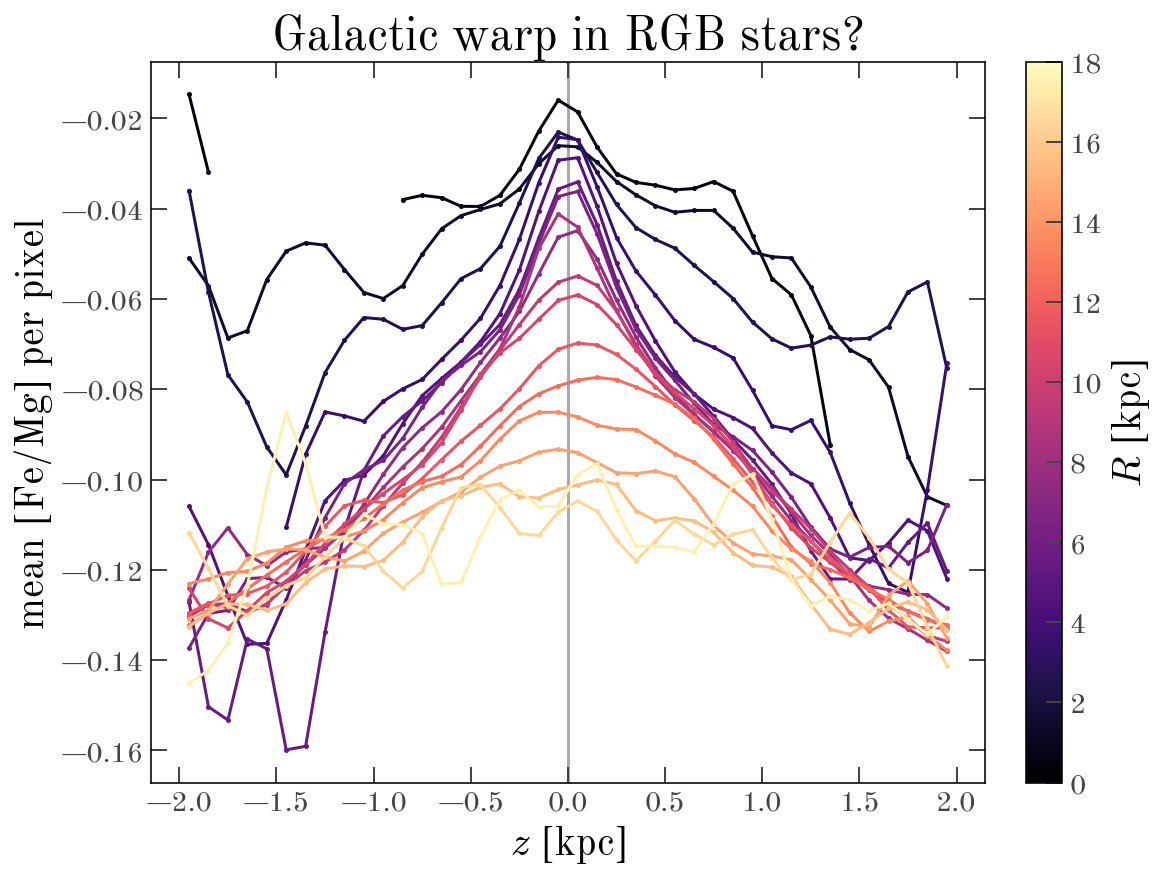

In [162]:
tmp_bins = (
    np.arange(0, 18 + 1e-3, 1.0),
    np.arange(-2, 2 + 1e-3, 0.1),
)

mask = rgb_mask & low_alpha_mask
stat = binned_statistic_2d(
    R[mask].to_value(u.kpc),
    galcen.z[mask].to_value(u.kpc),
    (unq_ipl["fe_h"] - unq_ipl["mg_h"])[mask],
    bins=tmp_bins,
)

cmap = plt.get_cmap("magma")
norm = mpl.colors.Normalize(tmp_bins[0].min(), tmp_bins[0].max())

tmp_binc1 = 0.5 * (tmp_bins[1][:-1] + tmp_bins[1][1:])
tmp_binc0 = 0.5 * (tmp_bins[0][:-1] + tmp_bins[0][1:])
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")

for i in range(stat.statistic.shape[0]):
    ax.plot(
        tmp_binc1,
        gaussian_filter1d(stat.statistic[i], 1),
        color=cmap(norm(tmp_binc0[i])),
    )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, ax=ax)
cb.set_label("$R$ [kpc]")

ax.axvline(0.0, zorder=-10, color="#aaaaaa")

ax.set(
    xlabel="$z$ [kpc]",
    ylabel="mean [Fe/Mg] per pixel",
    title="Galactic warp in RGB stars?",
)

# z-vz

In [191]:
zvz_bins = (np.linspace(-75, 75, 101), np.linspace(-1.5, 1.5, 101))

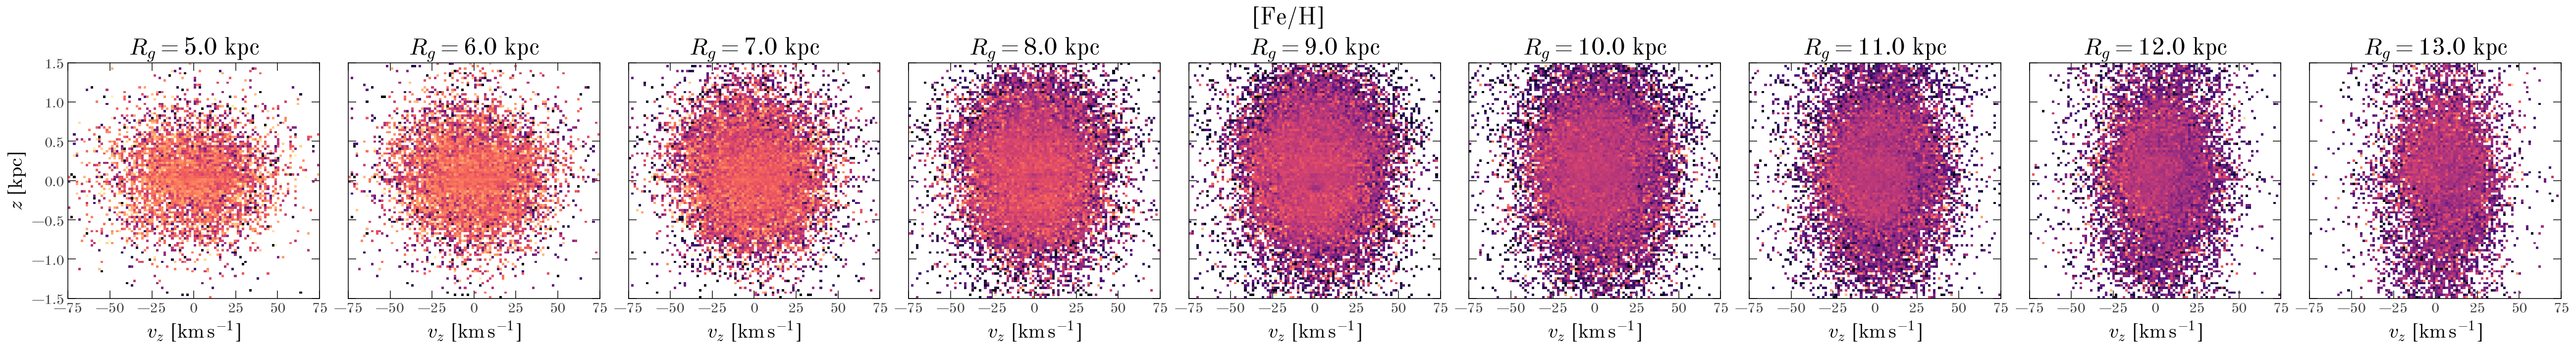

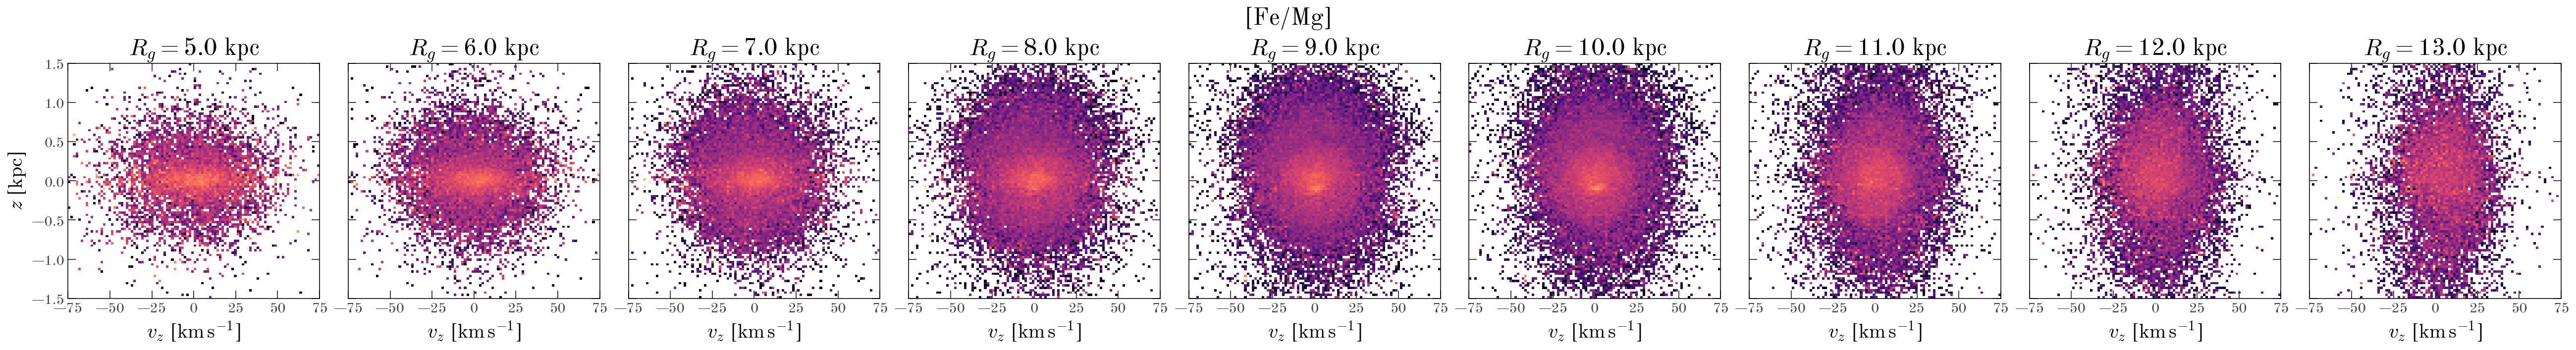

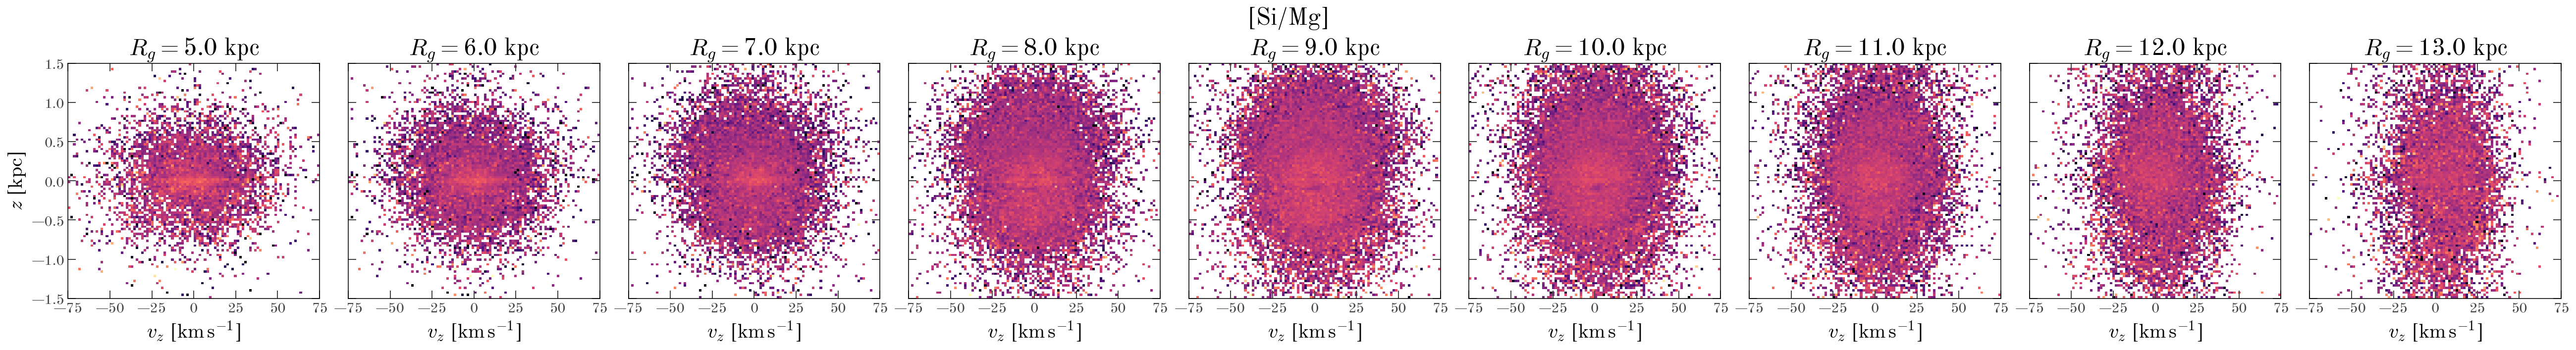

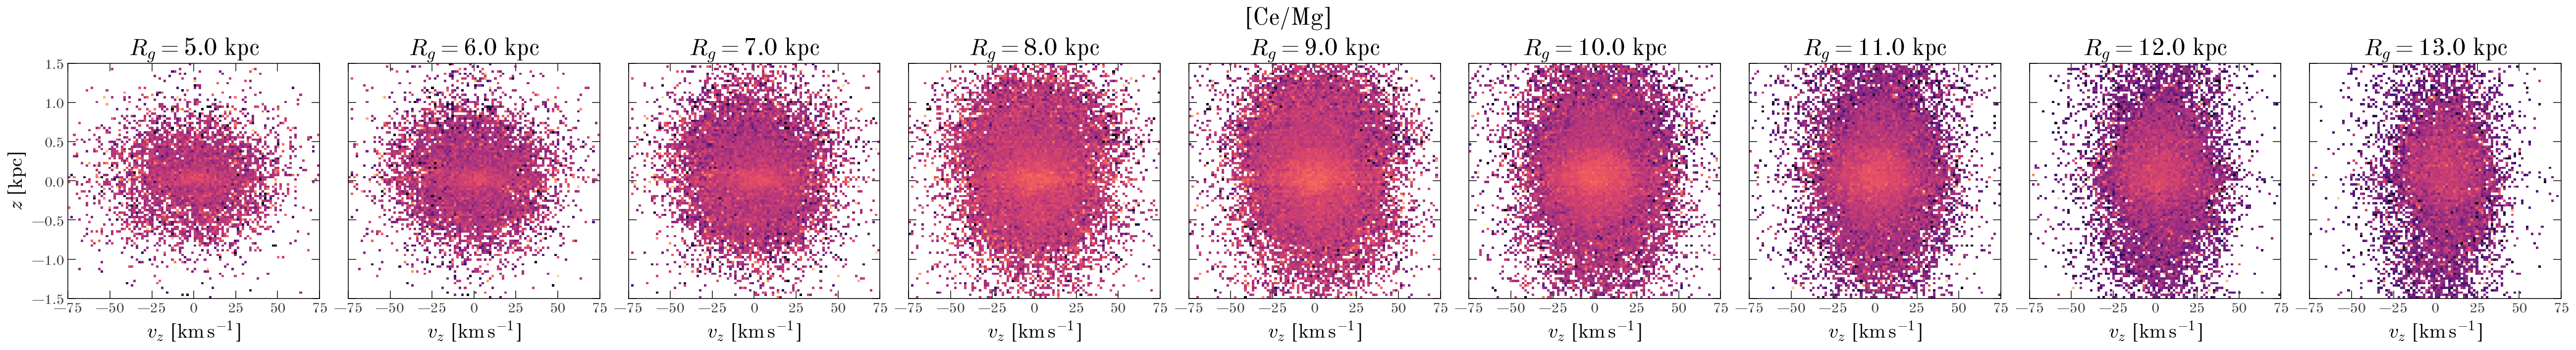

In [245]:
Rg_cs = np.arange(5.0, 14.0, 1.0) * u.kpc
dR = R - Rg

abuns = [
    unq_ipl["fe_h"],
    (unq_ipl["fe_h"] - unq_ipl["mg_h"]),
    (unq_ipl["si_h"] - unq_ipl["mg_h"]),
    (unq_ipl["ce_h"] - unq_ipl["mg_h"]),
]
abun_names = ["[Fe/H]", "[Fe/Mg]", "[Si/Mg]", "[Ce/Mg]"]

for abun, abun_name in zip(abuns, abun_names):
    fig, axes = plt.subplots(
        1,
        len(Rg_cs),
        figsize=(len(Rg_cs) * 4, 4.8),
        sharex=True,
        sharey=True,
        layout="constrained",
    )
    for ax, Rg_c in zip(axes.flat, Rg_cs):
        R_mask = (
            (np.abs(Rg - Rg_c) < 1.0 * u.kpc)
            & (np.abs(dR) < 2.0 * u.kpc)
            & (np.abs(vR) < 25 * u.km / u.s)
        )
        mask = R_mask & low_alpha_mask & rgb_mask
        # print(Rg_c, mask.sum())

        stat = binned_statistic_2d(
            galcen.v_z[mask].to_value(u.km / u.s),
            galcen.z[mask].to_value(u.kpc),
            abun[mask],
            bins=zvz_bins,
        )
        ax.pcolormesh(
            stat.x_edge,
            stat.y_edge,
            stat.statistic.T,
            vmin=np.nanpercentile(abun[mask], 1),
            vmax=np.nanpercentile(abun[mask], 99),
        )
        ax.set(xlabel=f"$v_z$ [{u.km/u.s:latex_inline}]", title=f"$R_g = ${Rg_c:.1f}")
    axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
    fig.suptitle(abun_name, fontsize=24)

# R-vR

In [246]:
RvR_bins = (np.linspace(-2, 5, 101), np.linspace(-100, 100, 101))

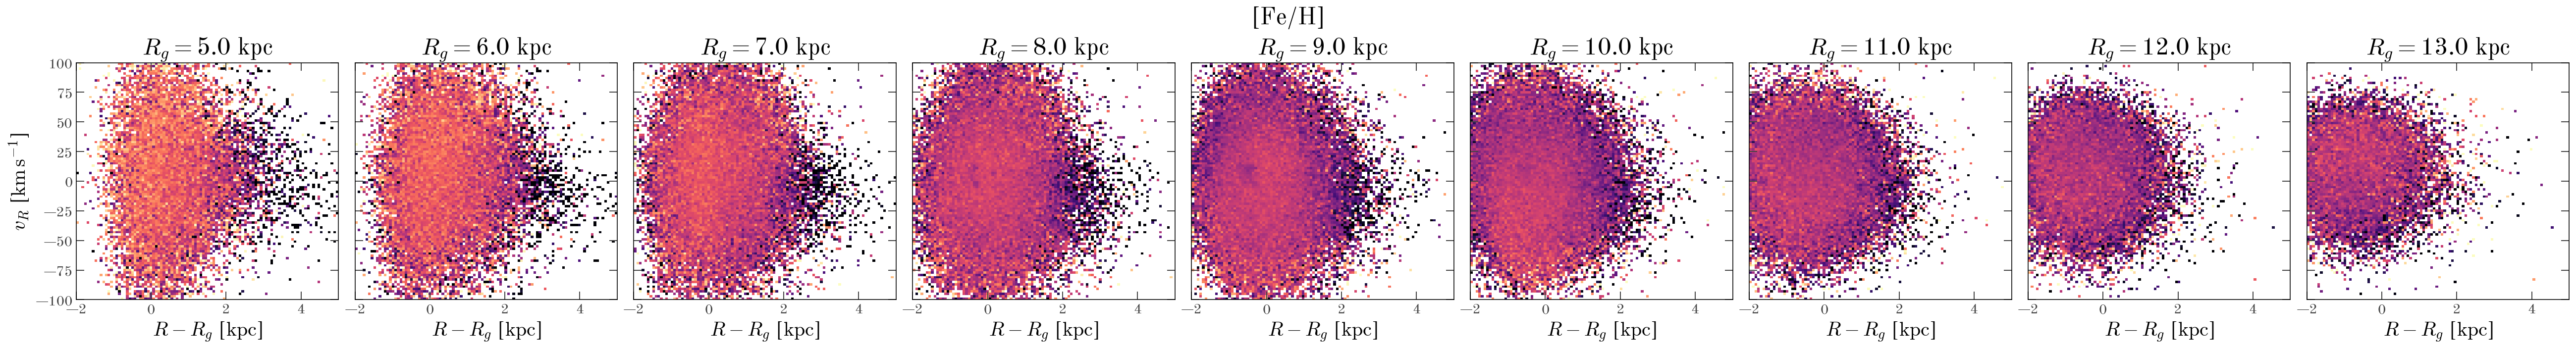

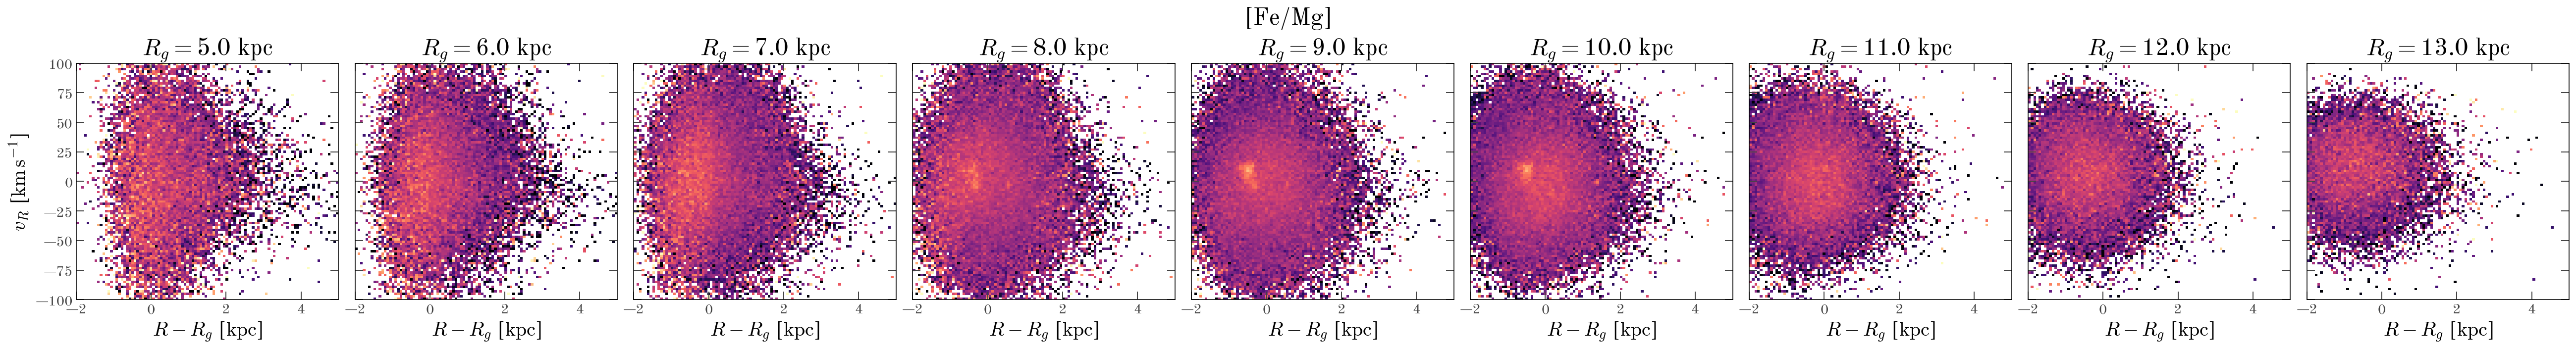

In [249]:
Rg_cs = np.arange(5.0, 14.0, 1.0) * u.kpc

abuns = [
    unq_ipl["fe_h"],
    (unq_ipl["fe_h"] - unq_ipl["mg_h"]),
]
abun_names = ["[Fe/H]", "[Fe/Mg]"]

dR = R - Rg
for abun, abun_name in zip(abuns, abun_names):
    fig, axes = plt.subplots(
        1,
        len(Rg_cs),
        figsize=(len(Rg_cs) * 4, 4.8),
        sharex=True,
        sharey=True,
        layout="constrained",
    )
    for ax, Rg_c in zip(axes.flat, Rg_cs):
        z_mask = (
            (np.abs(Rg - Rg_c) < 1 * u.kpc)
            & (np.abs(galcen.z) < 1 * u.kpc)
            & (np.abs(galcen.v_z) < 70 * u.km / u.s)
        )
        mask = z_mask & low_alpha_mask & rgb_mask

        stat = binned_statistic_2d(
            dR[mask].to_value(u.kpc),
            vR[mask].to_value(u.km / u.s),
            abun[mask],
            bins=RvR_bins,
        )
        ax.pcolormesh(
            stat.x_edge,
            stat.y_edge,
            stat.statistic.T,
            vmin=np.nanpercentile(abun[mask], 5),
            vmax=np.nanpercentile(abun[mask], 95),
        )
        ax.set(xlabel=f"$R - R_g$ [{u.kpc:latex_inline}]", title=f"$R_g = ${Rg_c:.1f}")
    axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]")
    fig.suptitle(abun_name, fontsize=24)

# Spin-up

[Text(0.5, 0, '[Fe/H]'), Text(0, 0.5, '$v_\\phi$ [$\\mathrm{km\\,s^{-1}}$]')]

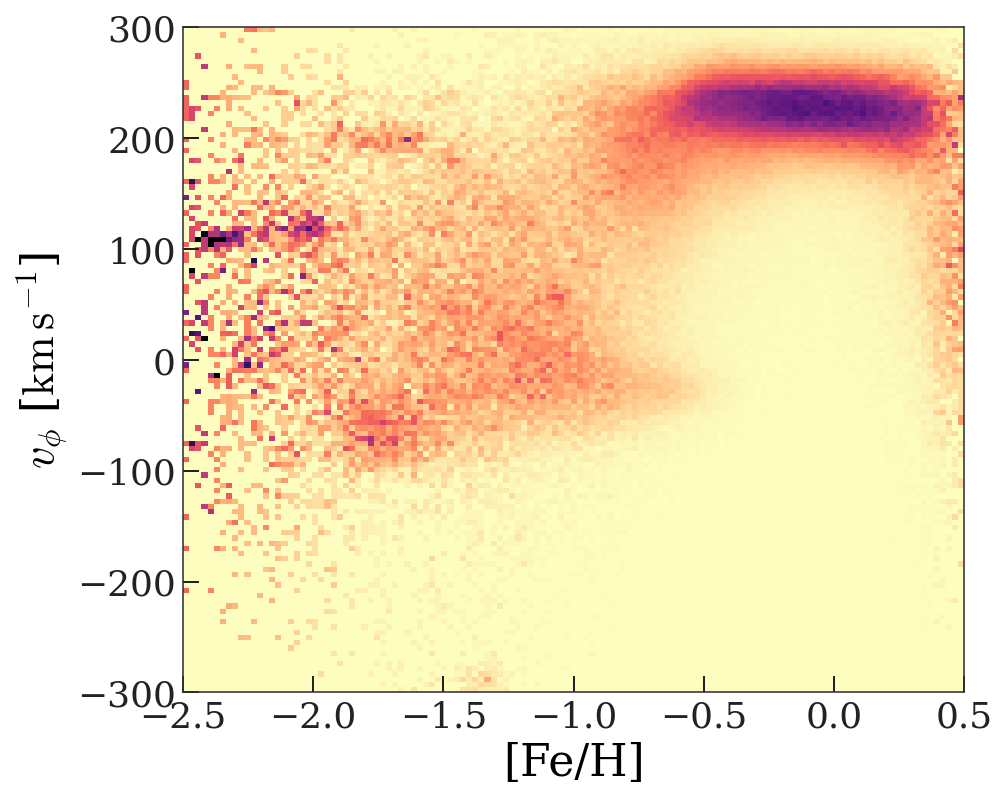

In [100]:
mask = rgb_mask & (unq_ipl['fe_h_flags'] == 0)

H, xe, ye = np.histogram2d(
    unq_ipl["fe_h"][mask],
    -vphi[mask],
    bins=(np.linspace(-2.5, 0.5, 128), np.linspace(-300, 300, 128)),
)

fig, ax = plt.subplots(figsize=(7, 6))
ax.pcolormesh(xe, ye, H.T / H.T.sum(axis=0), cmap="magma_r", vmax=0.1)
ax.set(xlabel="[Fe/H]", ylabel=r"$v_\phi$" + f" [{u.km/u.s:latex_inline}]")

# $R_g$ $z_{\rm max}$

In [30]:
Rg_size = 1. * u.kpc

Rg_bin_c = np.arange(5, 12, Rg_size.value) * u.kpc + Rg_size/2
zmax_bin_lr = [0, 0.2, 0.5, 1., 2., 5.] * u.kpc
n_zmax = zmax_bin_lr.size - 1

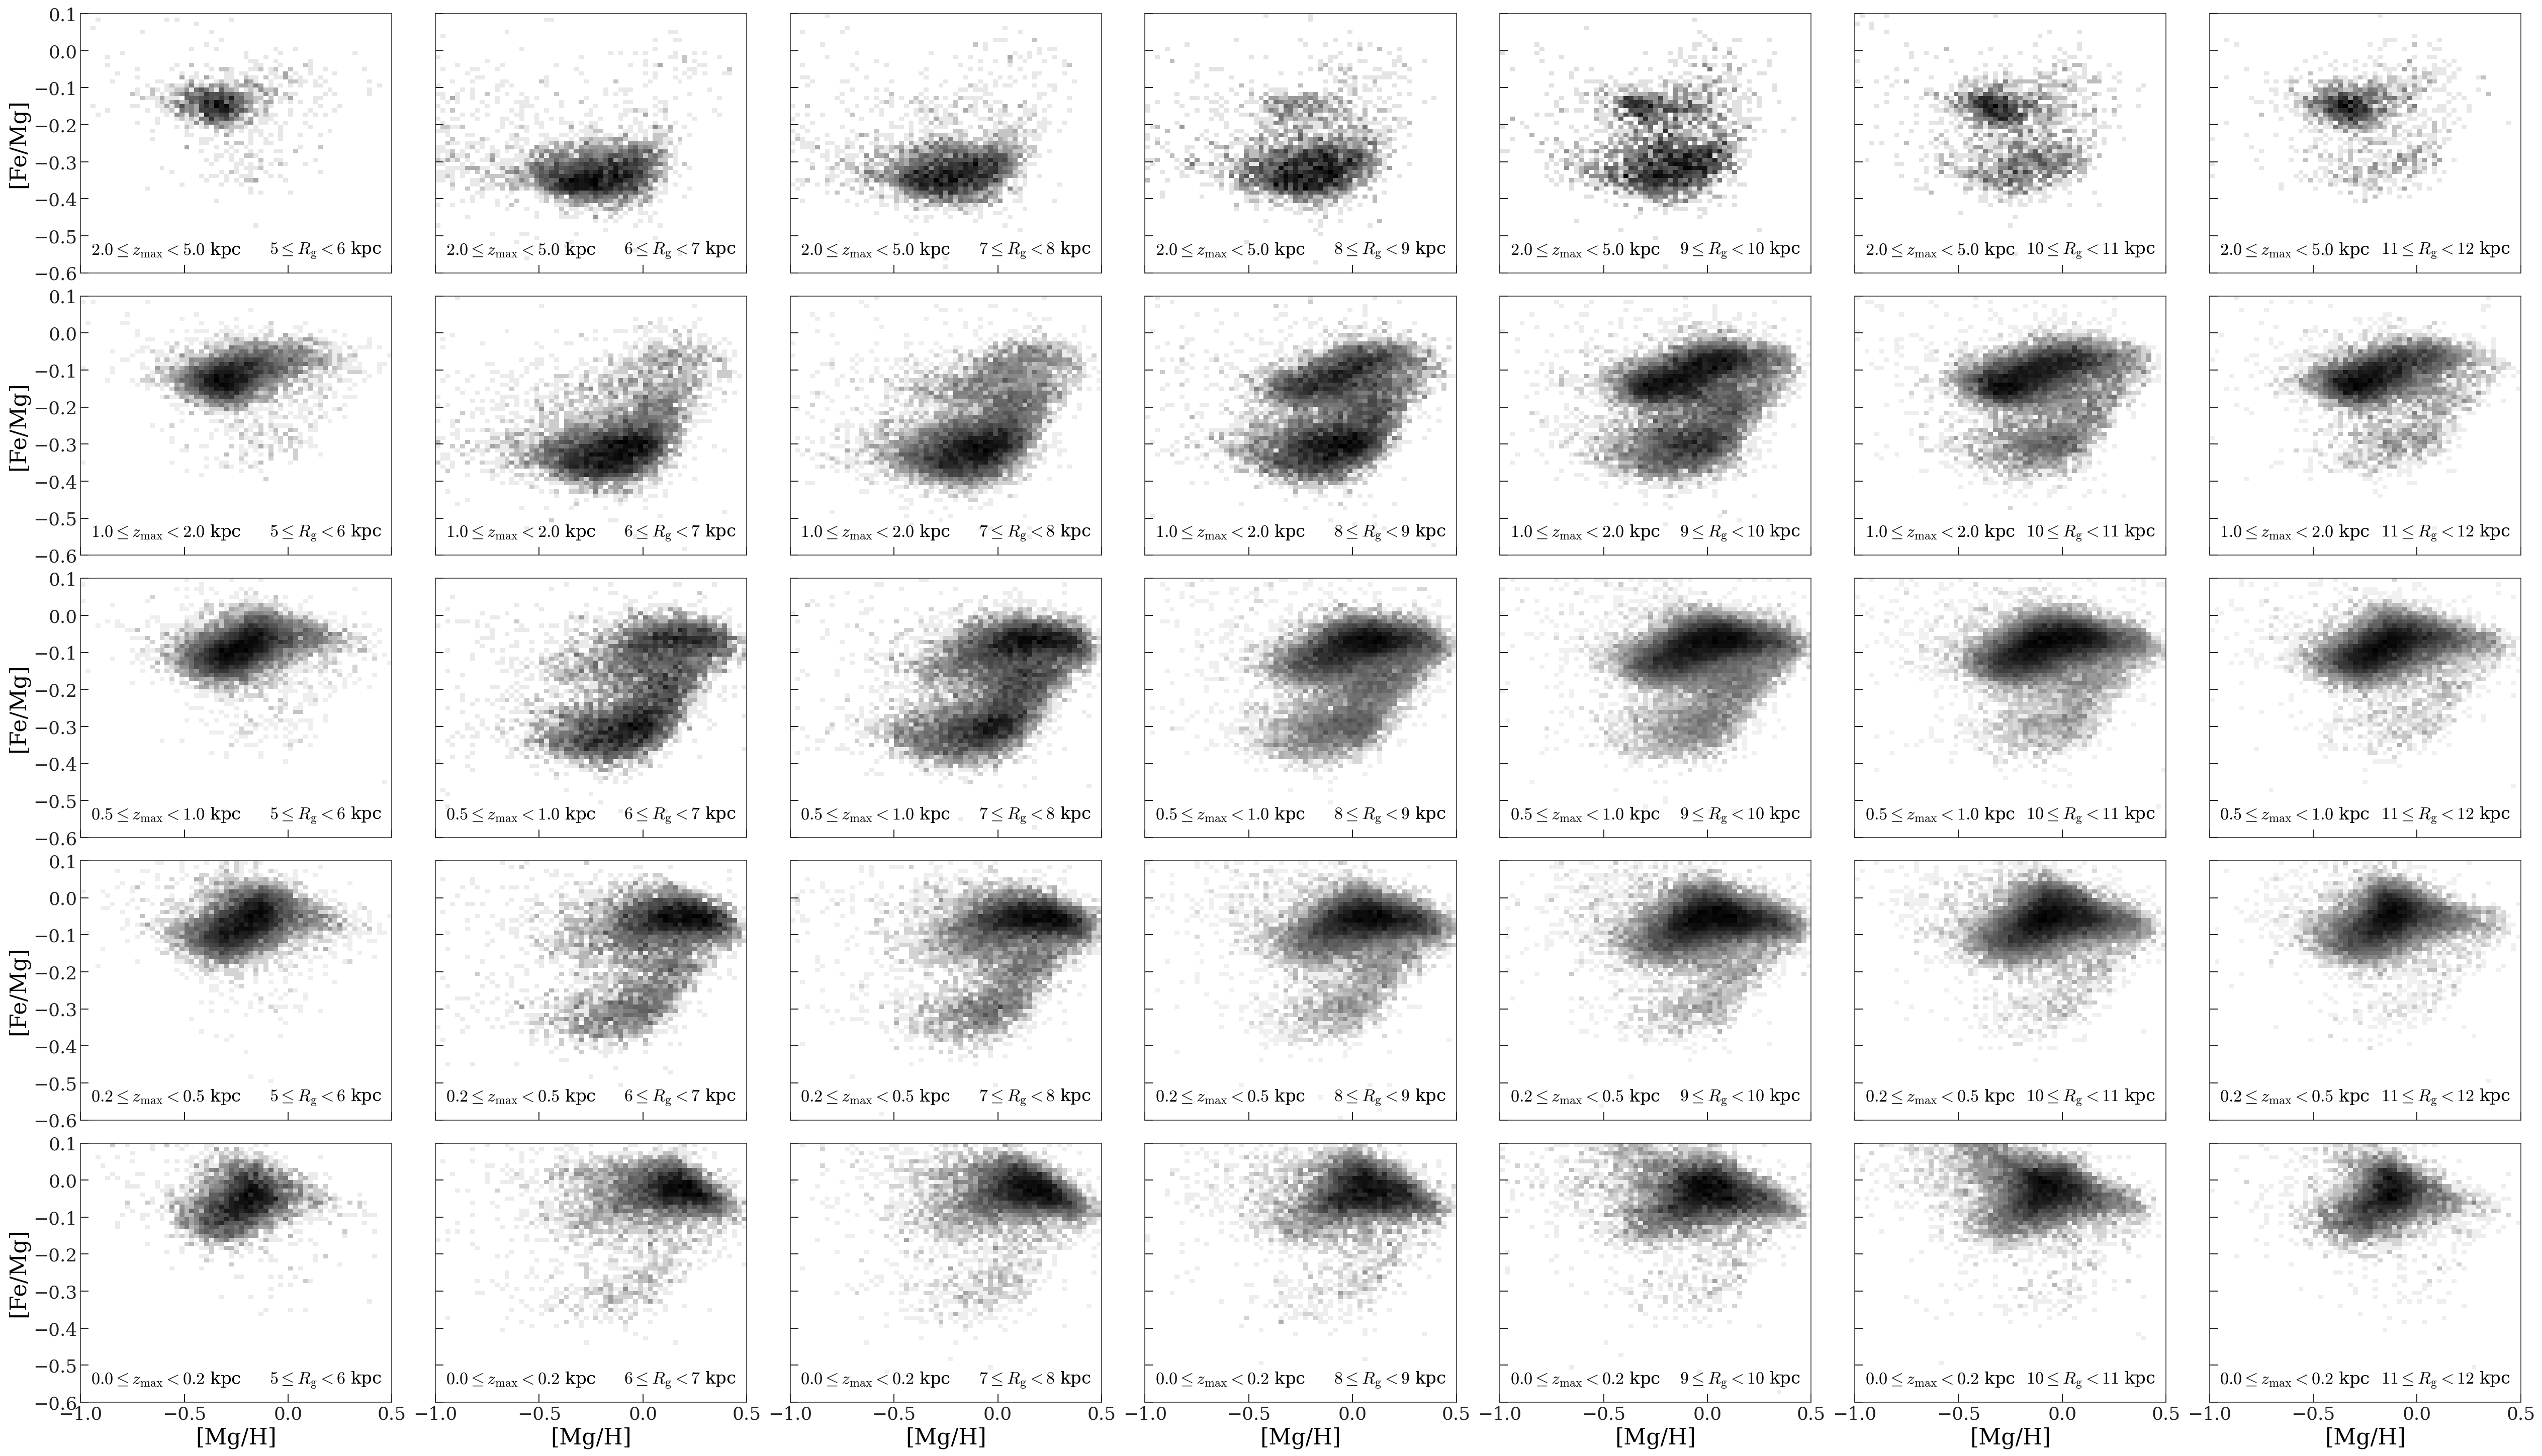

In [32]:
bins = (
    np.linspace(-1., 0.5, 64),
    np.linspace(-0.6, 0.1, 64)
)

fig, axes = plt.subplots(
    n_zmax, Rg_bin_c.size, 
    figsize=(Rg_bin_c.size * 5, n_zmax * 4),
    sharex=True, sharey=True, layout="constrained"
)

for i, Rg_c in enumerate(Rg_bin_c):
    Rg_mask = (Rg >= Rg_l) & (Rg < Rg_r)
    Rg_l = Rg_c - Rg_size/2
    Rg_r = Rg_c + Rg_size/2
    
    for j, (zmax_l, zmax_r) in enumerate(zip(zmax_bin_lr[:-1], zmax_bin_lr[1:])):
        zmax_mask = (zmax >= zmax_l) & (zmax < zmax_r)
        bin_mask = Rg_mask & zmax_mask & rgb_mask
        
        ax = axes[n_zmax - j - 1, i]
        
        ax.hist2d(
            unq_ipl["mg_h"][bin_mask],
            (unq_ipl["fe_h"] - unq_ipl["mg_h"])[bin_mask],
            bins=bins,
            norm=mpl.colors.LogNorm(0.5),
            cmap="Greys"
        )
        
        ax.text(
            -0.95, -0.55, 
            f"${zmax_l.value:.1f}" + r"\leq z_{\rm max} < " + f"{zmax_r.value:.1f}$ kpc", 
            ha="left", fontsize=17
        )
        ax.text(
            0.45, -0.55, 
            f"${Rg_l.value:.0f}" + r"\leq R_{\rm g} < " + f"{Rg_r.value:.0f}$ kpc", 
            ha="right", fontsize=17
        )

for ax in axes[:, 0]:
    ax.set_ylabel(r"[Fe/Mg]")
for ax in axes[-1]:
    ax.set_xlabel(r"[Mg/H]")